In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import truncnorm, norm
from scipy.optimize import fmin

### Read data

In [2]:
# Data set from https://www.kaggle.com/datasets/tunguz/big-five-personality-test
df = pd.read_csv("data/BIG5/data.csv", delimiter="\t")
print(df.shape)
df.head()

(19719, 57)


,race,age,engnat,gender,hand,source,country,E1,E2,E3,...,O1,O2,O3,O4,O5,O6,O7,O8,O9,O10
0,3,53,1,1,1,1,US,4,2,5,...,4,1,3,1,5,1,4,2,5,5
1,13,46,1,2,1,1,US,2,2,3,...,3,3,3,3,2,3,3,1,3,2
2,1,14,2,2,1,1,PK,5,1,1,...,4,5,5,1,5,1,5,5,5,5
3,3,19,2,2,1,1,RO,2,5,2,...,4,3,5,2,4,2,5,2,5,5
4,11,25,2,2,1,2,US,3,1,3,...,3,1,1,1,3,1,3,1,5,3


### Data pre-processing 

Some questions/statements, such as E2 ("I don't talk a lot") are "inverted" in the sense that a high score should contribute less to extraversion. We find these and invert the scores (1 -> 5, 2 -> 4...).

In [3]:
# First, drop columns except age, gender, and answers to the test questions
test_answers = [col for col in df.columns if col.isupper()]
cols_to_keep = test_answers + ['age', 'gender']
df_clean = df[cols_to_keep].copy()

# Only consider male (1) and female (2) genders
df_clean = df_clean[df_clean['gender'].isin([1, 2])]
df_clean['gender'] -= 1 # Male (0) and female (1)

inverse_score = {1:5, 2:4, 3:3, 4:2, 5:1}
inverse_questions = ['E2', 'E4', 'E6', 'E8', 'E10',
                    'N2', 'N4',
                    'A1', 'A3', 'A5', 'A7', 
                    'C2', 'C4', 'C6', 'C8', 
                    'O2', 'O4', 'O6']

# Invert scores for specified columns
df_clean[inverse_questions] = df_clean[inverse_questions].replace(inverse_score)

print(df_clean.shape)
df_clean.head()

(19593, 52)


,E1,E2,E3,E4,E5,E6,E7,E8,E9,E10,...,O3,O4,O5,O6,O7,O8,O9,O10,age,gender
0,4,4,5,4,5,5,4,3,5,5,...,3,5,5,5,4,2,5,5,53,0
1,2,4,3,3,3,3,1,1,1,1,...,3,3,2,3,3,1,3,2,46,1
2,5,5,1,2,5,5,1,1,5,5,...,5,5,5,5,5,5,5,5,14,1
3,2,1,2,2,3,2,3,2,4,1,...,5,4,4,4,5,2,5,5,19,1
4,3,5,3,3,3,5,3,5,3,1,...,1,5,3,5,3,1,5,3,25,1


### Distributions

First, we check the distribution of scores as histograms. The results for conscientiousness, extraversion and neuroticism look normally distributed, whereas the results for openness and agreeableness look skewed towards a higher score.

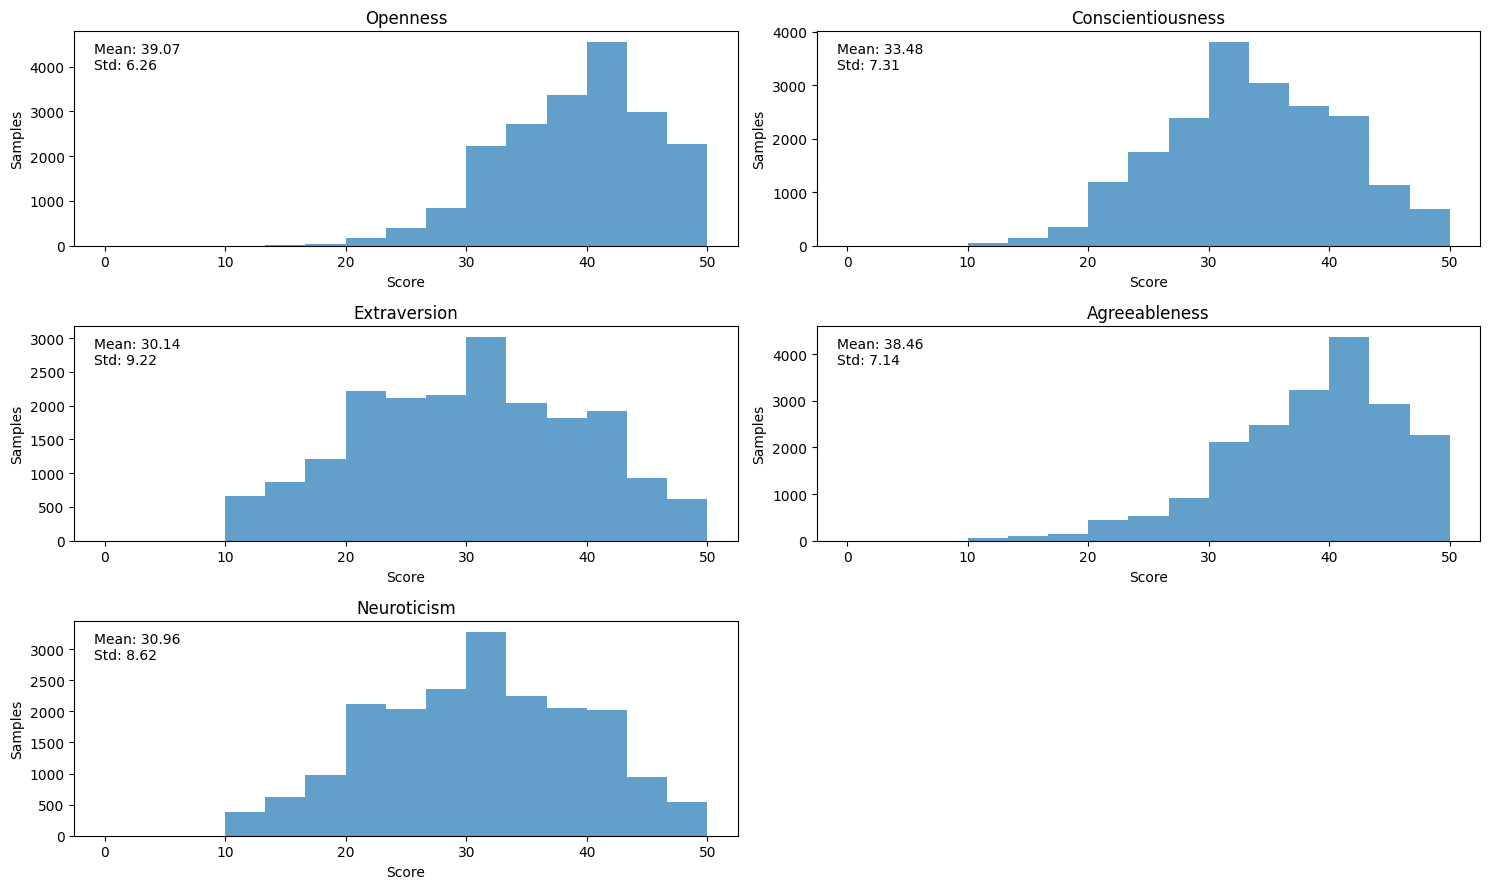

,E1,E2,E3,E4,E5,E6,E7,E8,E9,E10,...,O8,O9,O10,age,gender,Openness,Conscientiousness,Extraversion,Agreeableness,Neuroticism
0,4,4,5,4,5,5,4,3,5,5,...,2,5,5,53,0,43,47,44,46,11
1,2,4,3,3,3,3,1,1,1,1,...,1,3,2,46,1,26,42,22,35,31
2,5,5,1,2,5,5,1,1,5,5,...,5,5,5,14,1,45,49,35,38,46
3,2,1,2,2,3,2,3,2,4,1,...,2,5,5,19,1,41,26,22,37,43
4,3,5,3,3,3,5,3,5,3,1,...,1,5,3,25,1,34,34,34,44,30


In [4]:
traits = {
    'Openness': [f'O{i}' for i in range(1, 11)],
    'Conscientiousness': [f'C{i}' for i in range(1, 11)],
    'Extraversion': [f'E{i}' for i in range(1, 11)],
    'Agreeableness': [f'A{i}' for i in range(1, 11)],
    'Neuroticism': [f'N{i}' for i in range(1, 11)]
}

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 9))
axes = axes.flatten()

for (trait, columns), ax in zip(traits.items(), axes):
    df_clean[trait] = df_clean[columns].sum(axis=1)
    mu = df_clean[trait].mean()
    sigma = df_clean[trait].std()
    
    ax.hist(df_clean[trait], bins=15, alpha=0.7)

    ax.set_title(f'{trait}')
    ax.set_xlabel('Score')
    ax.set_ylabel('Samples')
    ax.text(0.03, 0.95, f'Mean: {mu:.2f}\nStd: {sigma:.2f}', transform=ax.transAxes, verticalalignment='top')

axes[5].axis('off')

plt.tight_layout()
plt.show()

df_clean.head()

We want to fit truncated normal distributions in the range [10, 50].

/home/adrimur/.local/lib/python3.8/site-packages/scipy/optimize/_optimize.py:863: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


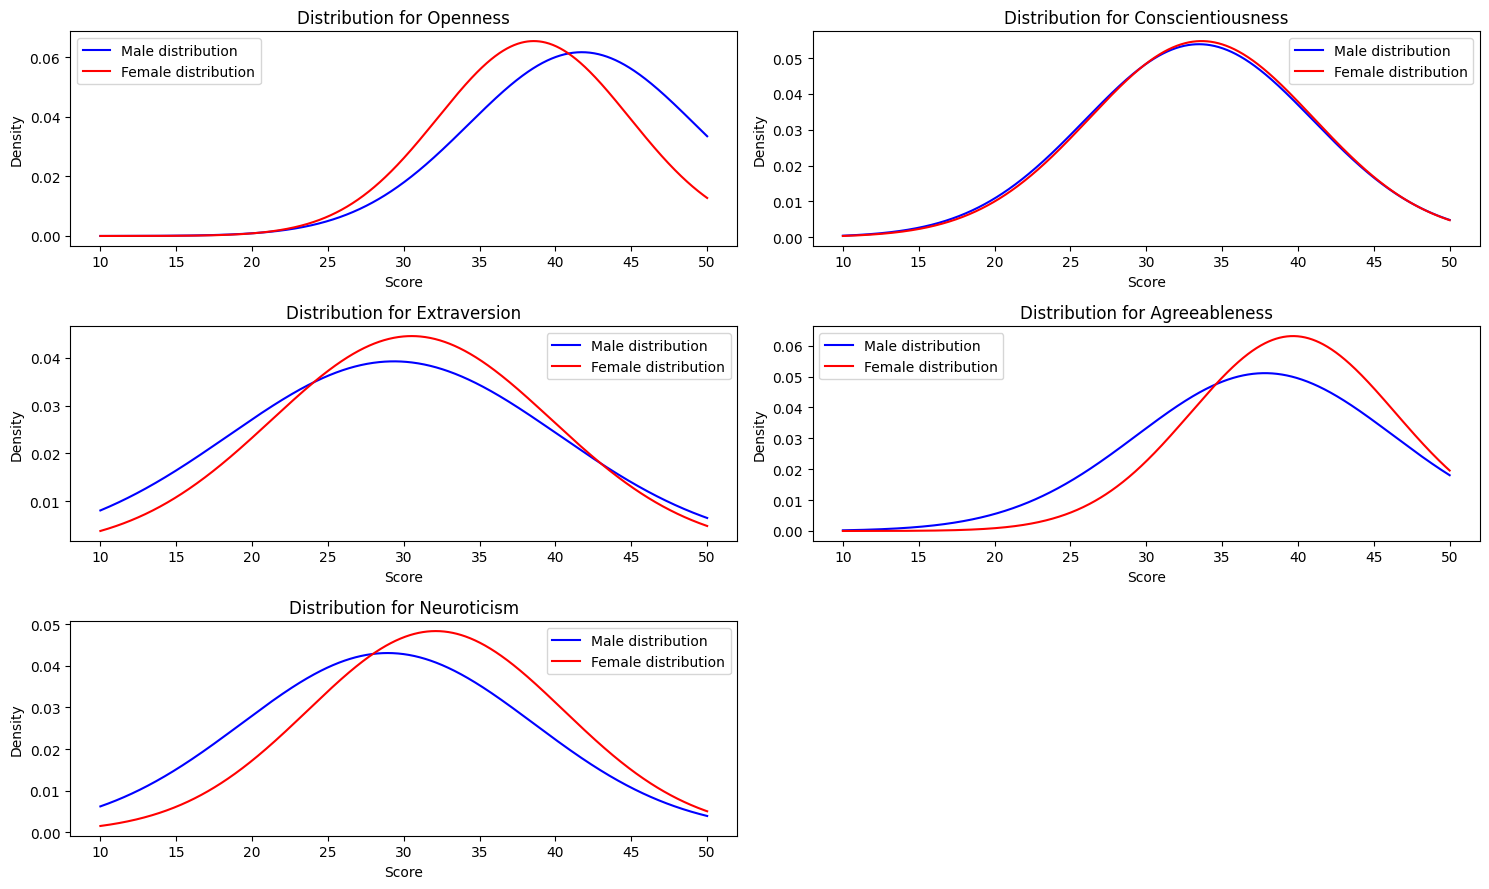

In [5]:
# Define a loss function to optimize against
def neg_log_likelihood(params, data, lower_bound, upper_bound):
    mu, sigma = params
    if sigma <= 0:
        return np.inf
    loglik = np.sum(truncnorm.logpdf(data, (lower_bound-mu)/sigma, (upper_bound-mu)/sigma, loc=mu, scale=sigma))
    return -loglik

lower_bound, upper_bound = 10, 50

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 9))
axes = axes.flatten()

for trait, ax in zip(traits.keys(), axes):
    for gender, color, label in zip([0, 1], ['b', 'r'], ['Male', 'Female']):
        data = df_clean[df_clean['gender'] == gender][trait].values
        # Initial parameter estimates
        mu_init, sigma_init = np.mean(data), np.std(data)
        params_init = [mu_init, sigma_init]

        # Find parameters that minimize the negative log-likelihood
        params_estimated = fmin(neg_log_likelihood, params_init, args=(data, lower_bound, upper_bound), disp=0)

        # Plot the estimated truncated normal distribution
        x = np.linspace(lower_bound, upper_bound, 1000)
        y = truncnorm.pdf(x, (lower_bound-params_estimated[0]) / params_estimated[1], \
                (upper_bound - params_estimated[0]) / params_estimated[1], loc=params_estimated[0], scale=params_estimated[1])
        ax.plot(x, y, color + '-', label=f'{label} distribution')
    
    ax.set_xlabel('Score')
    ax.set_ylabel('Density')
    ax.set_title(f'Distribution for {trait}')
    ax.legend()

axes[5].axis('off')

plt.tight_layout()
plt.show()

In [6]:
# We want equinumerous males and females in datasets
num_female = sum(df_clean['gender'] == 1)
num_male = sum(df_clean['gender'] == 0)

# Undersample the majority class to match the minority class
if num_female > num_male:
    df_female = df_clean[df_clean['gender'] == 1].sample(num_male, random_state=42)
    df_male = df_clean[df_clean['gender'] == 0]
else:
    df_male = df_clean[df_clean['gender'] == 0].sample(num_female, random_state=42)
    df_female = df_clean[df_clean['gender'] == 1]

df_balanced = pd.concat([df_female, df_male])

df_balanced.head()

,E1,E2,E3,E4,E5,E6,E7,E8,E9,E10,...,O8,O9,O10,age,gender,Openness,Conscientiousness,Extraversion,Agreeableness,Neuroticism
2384,1,1,1,2,2,1,2,2,2,1,...,4,4,5,15,1,41,26,15,26,33
18012,4,4,5,4,5,5,4,4,4,3,...,4,5,5,44,1,49,40,42,50,21
9033,3,4,3,4,3,4,3,4,4,3,...,2,5,3,14,1,34,38,35,34,38
12049,4,3,3,3,4,4,3,3,4,3,...,3,3,3,24,1,32,33,34,38,31
884,4,5,5,4,5,4,4,3,3,4,...,1,3,3,17,1,32,31,41,38,34


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

def evaluate(y_test, y_pred, model=''):
    print(f'Evaluating {model}\n---------------')
    print(f'Accuracy: {classification_report(y_test, y_pred)}')

labels = df_balanced['gender']
features = df_balanced[test_answers]

X_train, X_test, y_train, y_test = train_test_split(
    features, 
    labels, 
    test_size=0.8, 
    random_state=42,
    stratify=labels
)

In [8]:
from sklearn.linear_model import LogisticRegression

model_lr = LogisticRegression(random_state=42, max_iter=1000)
model_lr.fit(X_train, y_train)

y_pred = model_lr.predict(X_test)
evaluate(y_test, y_pred, model='Logistic Regression')

Evaluating Logistic Regression
---------------
Accuracy:               precision    recall  f1-score   support

           0       0.66      0.65      0.66      6087
           1       0.66      0.66      0.66      6086

    accuracy                           0.66     12173
   macro avg       0.66      0.66      0.66     12173
weighted avg       0.66      0.66      0.66     12173



In [9]:
from sklearn.neighbors import KNeighborsClassifier

model_knn = KNeighborsClassifier(n_neighbors=19)
model_knn.fit(X_train, y_train)

y_pred = model_knn.predict(X_test)
evaluate(y_test, y_pred, model='K-Nearest Neighbors')

Evaluating K-Nearest Neighbors
---------------
Accuracy:               precision    recall  f1-score   support

           0       0.64      0.58      0.61      6087
           1       0.61      0.67      0.64      6086

    accuracy                           0.62     12173
   macro avg       0.63      0.62      0.62     12173
weighted avg       0.63      0.62      0.62     12173



In [10]:
from sklearn import svm

model_svm = svm.SVC(decision_function_shape='ovo', probability=True)
model_svm.fit(X_train, y_train)

y_pred = model_svm.predict(X_test)
evaluate(y_test, y_pred, model='Support Vector Machine')

Evaluating Support Vector Machine
---------------
Accuracy:               precision    recall  f1-score   support

           0       0.66      0.67      0.66      6087
           1       0.66      0.66      0.66      6086

    accuracy                           0.66     12173
   macro avg       0.66      0.66      0.66     12173
weighted avg       0.66      0.66      0.66     12173



### But what if...

We consider the big five traits of men and women to be two separate truncated multivariate normal distributions, and look at the probability that a point - with the scores for each personality trait - was sampled from either distribution?

### Conclusion

SVM is favored.